# Beans on Reißzahn

In [1]:
from __future__ import unicode_literals
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.chat
import common.live
import common.videos

In [2]:
class ComparisonType:
    week, week_no_weekend, weekday = range(3)

def annotateBar(plot, ndigits=0):
    for p in plot.patches:
        num = round(p.get_height(), ndigits=ndigits)
        if ndigits == 0:
            num = int(num)
        if p.get_y() < 0:
            num = -num
        x = p.get_x() + p.get_width() / 2.0
        y = p.get_y() + p.get_height()
        plot.annotate(str(num), 
                      xy=(x, y), 
                      ha='center', 
                      va='bottom')
    plot.margins(.05)

In [3]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
pd.set_option('display.max_columns', None)
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/live'
VIDEO_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/video'

#shows
shows = [{
    'name': 'Reißzahn 04.05.2016',
    'start': datetime.datetime(2016, 5, 4, 20, 15, 0),
    'end': datetime.datetime(2016, 5, 4, 22, 15, 0),
    'videos': ['fIath416SBM',
               'kM2LOsCyWqE',
               'n0wJNJSZxE4']
}, {
    'name': 'Reißzahn 25.10.2016',
    'start': datetime.datetime(2016, 10, 25, 20, 15, 0),
    'end': datetime.datetime(2016, 10, 25, 22, 25, 0),
    'videos': []
}]

#live viewers margin left
liveMarginLeft = datetime.timedelta(hours=3)

#live viewers margin right
liveMarginRight = datetime.timedelta(hours=3)

#relative live viewers change left span
changeSpanLeft = datetime.timedelta(weeks=2)

#relative live viewers change right span
changeSpanRight = datetime.timedelta()

#relative live viewers change comparison type
comparison = ComparisonType.week_no_weekend

In [4]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')
live['weekday'] = live.index.dayofweek

In [5]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

#create additional column
chat['day'] = chat.index.strftime('%Y-%m-%d')

In [6]:
#load video data
videos, videosHosts, videosShows = common.videos.load(VIDEO_DATA_DIRECTORY)

#create additional column
videos['ratings_total'] = videos['likeCount'] + videos['dislikeCount']
videos['ratings_ratio'] = 100 * videos['likeCount'] / videos['ratings_total']

## Berechnungen

In [7]:
data = pd.DataFrame(columns=['live_views_mean', 
                             'live_views_slope',
                             'live_views_comp_mean', 
                             'live_views_comp_median', 
                             'live_change_mean', 
                             'live_change_median',
                             'chat_messages',
                             'chat_participants',
                             'chat_ratio',
                             'video_views_total',
                             'video_views_mean',
                             'video_views_drop',
                             'video_ratings_total',
                             'video_ratings_mean',
                             'video_ratings_like_total',
                             'video_ratings_like_mean',
                             'video_ratings_dislike_total',
                             'video_ratings_dislike_mean',
                             'video_ratings_ratio_total',
                             'video_ratings_ratio_mean',
                             'video_comments_total',
                             'video_comments_mean'])

for show in shows:
    cols = []

    #=================== live data ===================
    #filter live data by date
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveViewsMean = float(liveFiltered.mean())

    #calculate linear regression
    x = np.array(liveFiltered.index.strftime('%s').tolist()).astype(int)
    y = np.array(liveFiltered['viewers'].tolist())
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    liveViewsSlope = slope

    #start/end date (comparision period)
    startDate = show['start'] - changeSpanLeft
    startDate = startDate.replace(hour=0, minute=0, second=0)
    endDate = show['start'] + changeSpanRight
    endDate = endDate.replace(hour=11, minute=59, second=59)

    #filter live data by date (comparision period)
    liveCompFiltered = live.loc[startDate : endDate]

    if comparison == ComparisonType.week:
        #no additional filter necessary
        pass
    elif comparison == ComparisonType.week_no_weekend:
        workingDays = range(0,5)
        liveCompFiltered = liveCompFiltered[liveCompFiltered['weekday'].isin(workingDays)]
    elif comparison == ComparisonType.weekday:
        liveCompFiltered = liveCompFiltered[liveCompFiltered['weekday'] == show['date'].weekday()]

    liveCompGrouped = liveCompFiltered.groupby('day')
    liveCompMean = liveCompGrouped.apply(lambda group: group['viewers'].mean())
    liveCompMean = liveCompMean.to_frame('viewers')

    #calculate mean & median (comparision period)
    liveViewsCompMean = float(liveCompMean.mean())
    liveViewsCompMedian = float(liveCompMean.median())

    #calculate change (mean)
    liveViewsChangeMean = 100 * (liveViewsMean - liveViewsCompMean) / liveViewsCompMean

    #calculate change (median)
    liveViewsChangeMedian = 100 * (liveViewsMean - liveViewsCompMedian) / liveViewsCompMedian

    cols.append(liveViewsMean)
    cols.append(liveViewsSlope)
    cols.append(liveViewsCompMean)
    cols.append(liveViewsCompMedian)
    cols.append(liveViewsChangeMean)
    cols.append(liveViewsChangeMedian)

    #=================== chat data ===================
    #chat data
    chatFiltered = chat.loc[show['start'] : show['end']]
    chatMessages = len(chatFiltered)
    chatParticipants = len(chatFiltered['username'].unique())

    #chat participants to live viewers ratio
    chatRatio = chatParticipants / liveViewsMean

    cols.append(chatMessages)
    cols.append(chatParticipants)
    cols.append(chatRatio)

    #=================== video data ===================
    #filter videos by id
    videosFiltered = videos[videos.index.isin(show['videos'])]

    if len(videosFiltered) > 0:
        #views
        videoViewsTotal = videosFiltered['viewCount'].sum()
        videoViewsMean = videosFiltered['viewCount'].mean()
        videoViewsDrop = float('NaN')
        if (len(videosFiltered) > 1):
            firstVideo = videosFiltered['viewCount'][0]
            secondVideo = videosFiltered['viewCount'][1]
            videoViewsDrop = 100 * (firstVideo - secondVideo) / float(firstVideo)

        #ratings
        videoRatingsTotal = videosFiltered['ratings_total'].sum()
        videoRatingsMean = videosFiltered['ratings_total'].mean()

        #likes
        videoRatingsLikeTotal = videosFiltered['likeCount'].sum()
        videoRatingsLikeMean = videosFiltered['likeCount'].mean()

        #dislikes
        videoRatingsDislikeTotal = videosFiltered['dislikeCount'].sum()
        videoRatingsDislikeMean = videosFiltered['dislikeCount'].mean()

        #ratio
        videoRatingsRatioTotal = 100 * videoRatingsLikeTotal / float(videoRatingsTotal)
        videoRatingsRatioMean = videosFiltered['ratings_ratio'].mean()

        #comments
        videoCommentsTotal = videosFiltered['commentCount'].sum()
        videoCommentsMean = videosFiltered['commentCount'].mean()

        cols.append(videoViewsTotal)
        cols.append(videoViewsMean)
        cols.append(videoViewsDrop)
        cols.append(videoRatingsTotal)
        cols.append(videoRatingsMean)
        cols.append(videoRatingsLikeTotal)
        cols.append(videoRatingsLikeMean)
        cols.append(videoRatingsDislikeTotal)
        cols.append(videoRatingsDislikeMean)
        cols.append(videoRatingsRatioTotal)
        cols.append(videoRatingsRatioMean)
        cols.append(videoCommentsTotal)
        cols.append(videoCommentsMean)
    else:
        cols.extend([float('NaN')] * 13)

    #=================== build dataframe ===================
    data.loc[show['name']] = cols

data

,live_views_mean,live_views_slope,live_views_comp_mean,live_views_comp_median,live_change_mean,live_change_median,chat_messages,chat_participants,chat_ratio,video_views_total,video_views_mean,video_views_drop,video_ratings_total,video_ratings_mean,video_ratings_like_total,video_ratings_like_mean,video_ratings_dislike_total,video_ratings_dislike_mean,video_ratings_ratio_total,video_ratings_ratio_mean,video_comments_total,video_comments_mean
Reißzahn 04.05.2016,13884.950413,0.195961,3414.290152,3453.947917,306.671659,302.002310,38715.0,4224.0,0.304214,149897.0,49965.666667,37.963428,4379.0,1459.666667,4266.0,1422.0,113.0,37.666667,97.419502,97.623583,563.0,187.666667
Reißzahn 25.10.2016,9703.114504,-0.028329,2284.976778,2380.871528,324.648276,307.544649,9514.0,1962.0,0.202203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Live Zuschauer

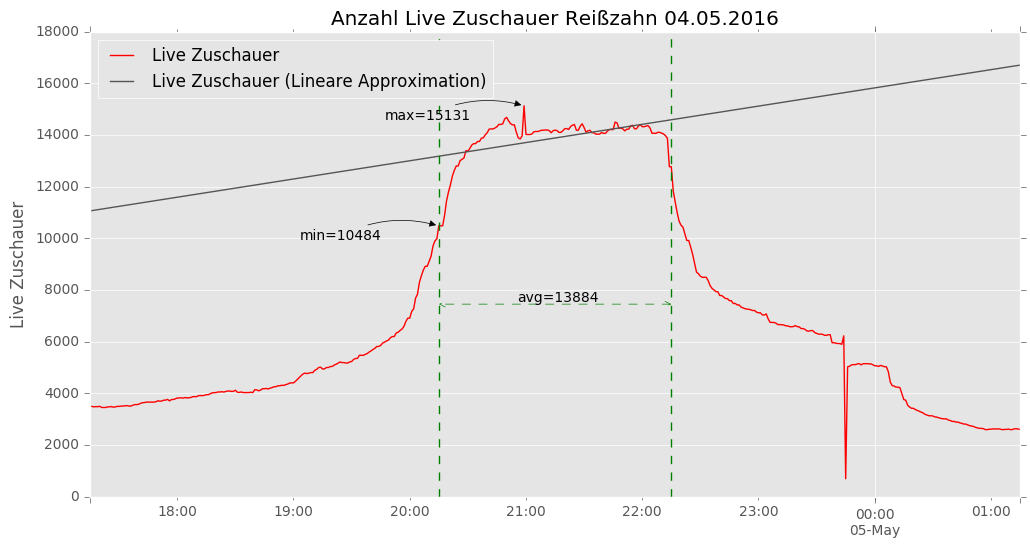

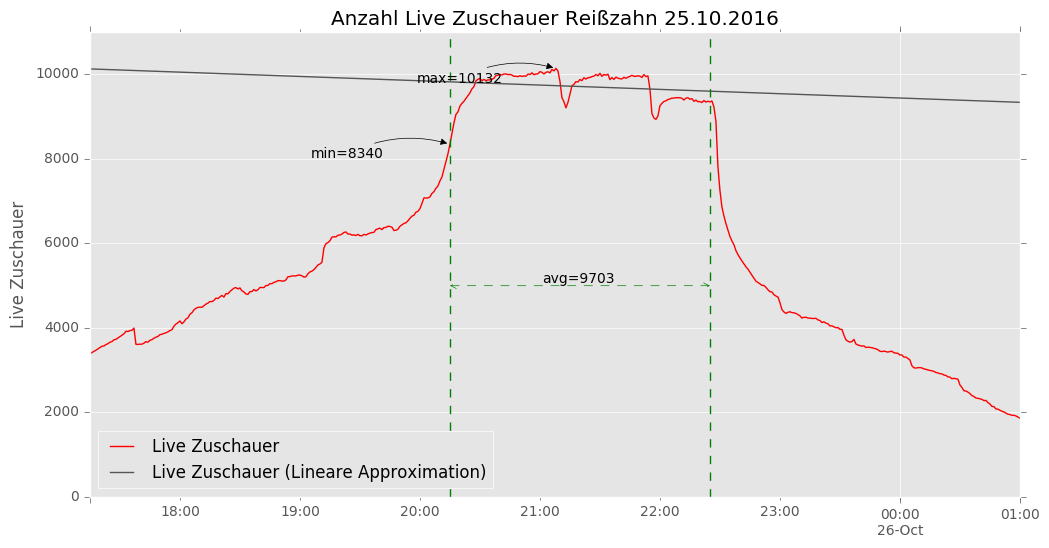

In [8]:
for show in shows:
    #filter live data by date
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveViewsMean = float(liveFiltered.mean())

    #live data (with margin)
    dateStart = show['start'] - liveMarginLeft
    dateEnd = show['end'] + liveMarginRight
    liveFilteredMargin = live.loc[dateStart : dateEnd]['viewers'].to_frame('viewers')

    #calculate linear regression
    x = np.array(liveFiltered.index.strftime('%s').tolist()).astype(int)
    y = np.array(liveFiltered['viewers'].tolist())
    slope, intercept, r_value, p_value, std_err = linregress(x,y)

    x = np.array(liveFilteredMargin.index.strftime('%s').tolist()).astype(int)
    y = intercept + slope * x

    liveFilteredMargin['regression'] = y

    #plot
    plot = liveFilteredMargin.plot(figsize=(12, 6), color=['r', '#555555'], legend=False, title='Anzahl Live Zuschauer %s' % show['name'])
    plot.set_xlabel('')
    plot.set_ylabel('Live Zuschauer')

    legend = plot.legend(loc=0)
    legend.get_texts()[0].set_text('Live Zuschauer')
    legend.get_texts()[1].set_text('Live Zuschauer (Lineare Approximation)')

    plt.ylim(ymin=0)

    #annotate min
    datapointMin = {
        'x': liveFiltered.idxmin()[0],
        'y': liveFiltered.min()[0]
    }
    plot.annotate('min=%d' % datapointMin['y'], 
                  xy=(datapointMin['x'], datapointMin['y']), xycoords='data', 
                  xytext=(-100, -10), textcoords='offset points',
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle='arc3,rad=-0.2',
                                  linewidth = 0.5,
                                  color = 'black')
                 )

    #annotate max
    datapointMax = {
        'x': liveFiltered.idxmax()[0],
        'y': liveFiltered.max()[0]
    }
    plot.annotate('max=%d' % datapointMax['y'], 
                  xy=(datapointMax['x'], datapointMax['y']), xycoords='data', 
                  xytext=(-100, -10), textcoords='offset points',
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle='arc3,rad=-0.2',
                                  linewidth = 0.5,
                                  color = 'black')
                 )

    #annotate avg
    dateMiddle = (show['start'] + (show['end'] - show['start']) / 2)
    plot.annotate('', 
                  xy=(show['start'], datapointMax['y'] / 2.03), xycoords='data', 
                  xytext=(show['end'], datapointMax['y'] / 2.03), textcoords='data',
                  arrowprops=dict(edgecolor='g', arrowstyle = '<->', linestyle='--', shrinkA=0, shrinkB=0)
                  )
    plot.annotate('avg=%d' % liveViewsMean, 
                  xy=(dateMiddle, datapointMax['y'] / 2), xycoords='data', 
                  xytext=(-27, 0), textcoords='offset points')

    #start/end times
    plot.axvline(show['start'], color='g', linestyle='--')
    plot.axvline(show['end'], color='g', linestyle='--')

(0, 14579.197933884298)

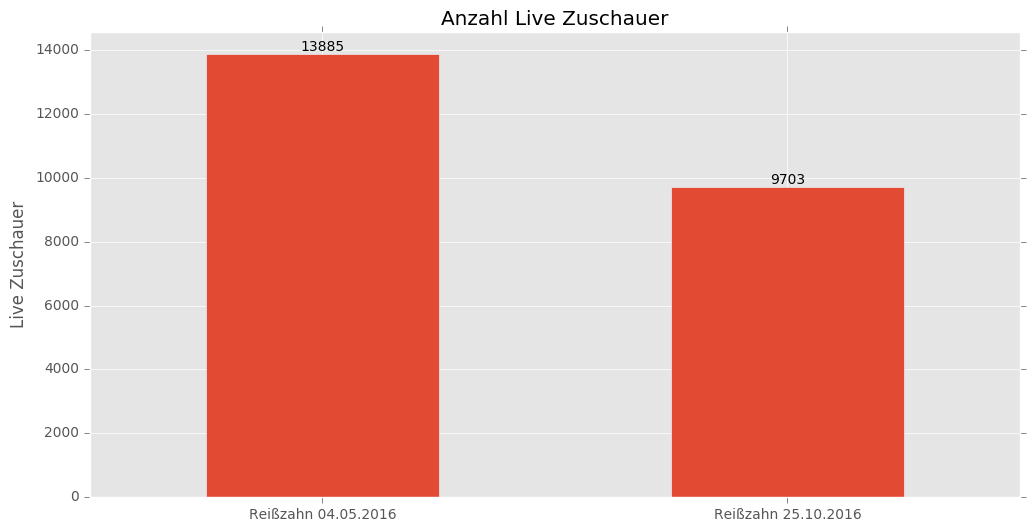

In [9]:
plot = data['live_views_mean'].plot(kind='bar', figsize=(12, 6), title='Anzahl Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Relative Live Zuschauer Änderung

Die relative Änderung der Live Zuschauer bezieht sich auf den Vergleich der durchschnittlichen Live Zuschauer während des Events, mit dem Durchschnitt und Median über einige Wochen aus dem Zeitraum. Je stärker die Änderung, desto stärker hebt sich das Event im Bezug auf die Live-Zuschauer vom üblichen Programm in dem lokalen Zeitraum ab.

(0, 3626.6453124999998)

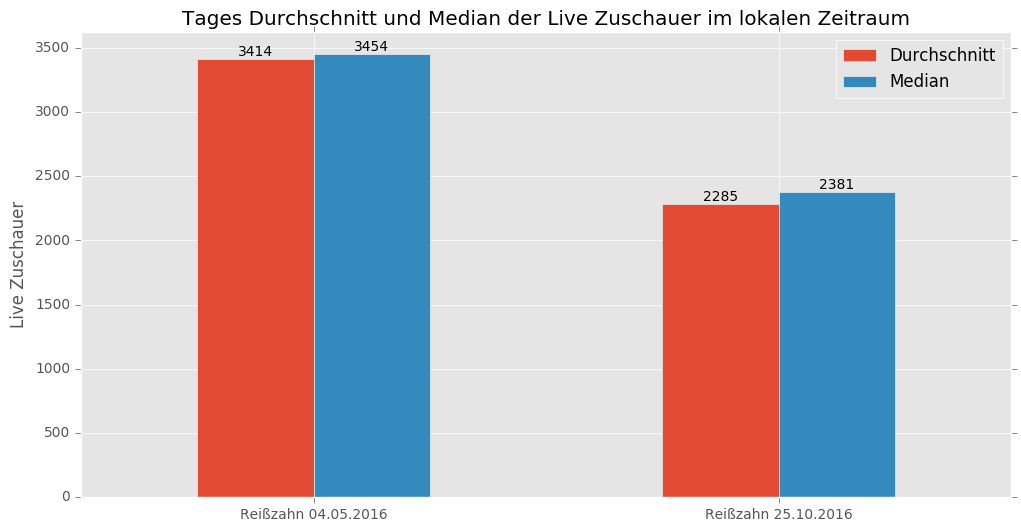

In [10]:
plot = data[['live_views_comp_mean', 'live_views_comp_median']].plot(kind='bar', figsize=(12, 6), title='Tages Durchschnitt und Median der Live Zuschauer im lokalen Zeitraum')
plot.set_ylabel('Live Zuschauer')

legend = plot.legend(loc=0)
legend.get_texts()[0].set_text('Durchschnitt')
legend.get_texts()[1].set_text('Median')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 340.88069017661934)

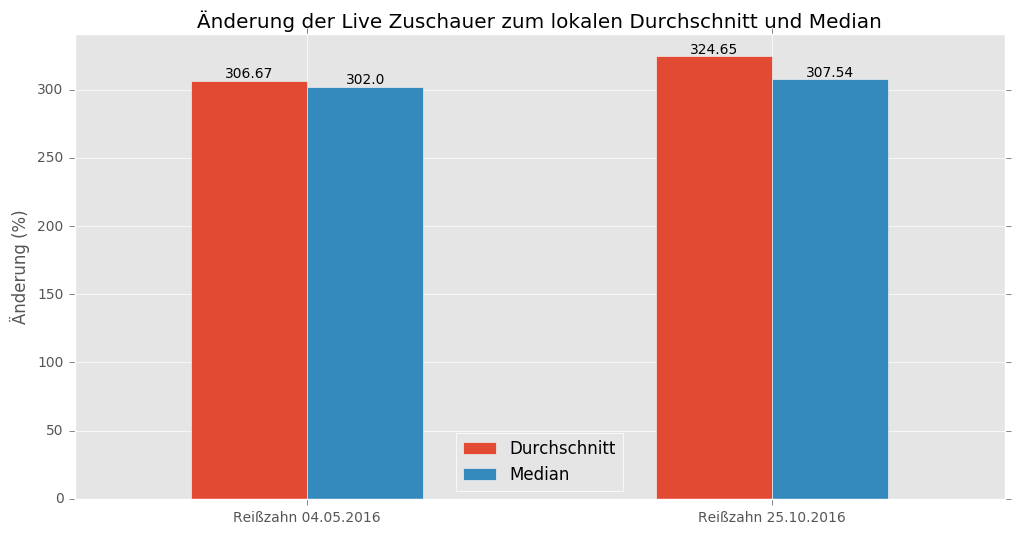

In [11]:
plot = data[['live_change_mean', 'live_change_median']].plot(kind='bar', figsize=(12, 6), title='Änderung der Live Zuschauer zum lokalen Durchschnitt und Median')
plot.set_ylabel('Änderung (%)')

legend = plot.legend(loc=0)
legend.get_texts()[0].set_text('Durchschnitt')
legend.get_texts()[1].set_text('Median')

annotateBar(plot, ndigits=2)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Live Zuschauer Steigung

Die Steigung der lineare Approximation der Live Zuschauer, vom Anfang bis zum Ende des Events. Diese Gerade ist auch oben in den Diagrammen zum Verlauf der Live Zuschauer eingezeichnet. Ein negativer Wert stellt einen Zuschauerschwund dar, ein positiver Wert einen Zuschauerwachstum.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

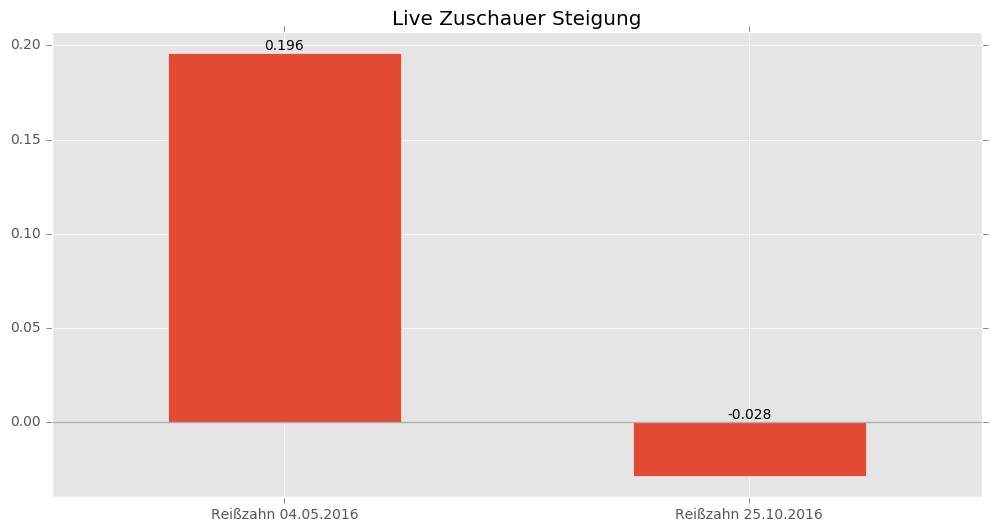

In [12]:
plot = data['live_views_slope'].plot(kind='bar', figsize=(12, 6), title='Live Zuschauer Steigung')

plt.axhline(y=0, color='#afafaf')

annotateBar(plot, ndigits=3)

plt.xticks(rotation=0)

## Chat Nachrichten & Teilnehmer

(0, 40650.75)

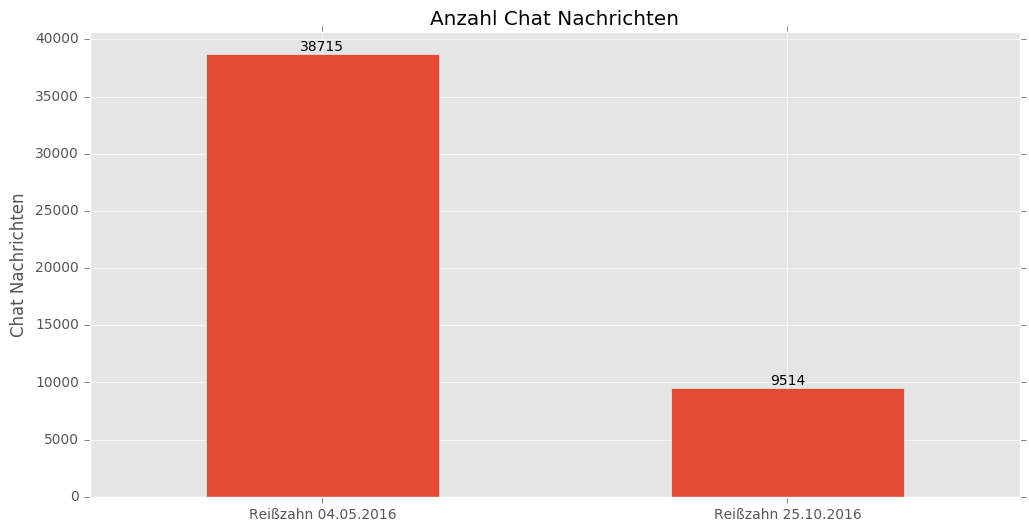

In [13]:
plot = data['chat_messages'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Nachrichten')
plot.set_ylabel('Chat Nachrichten')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 4435.1999999999998)

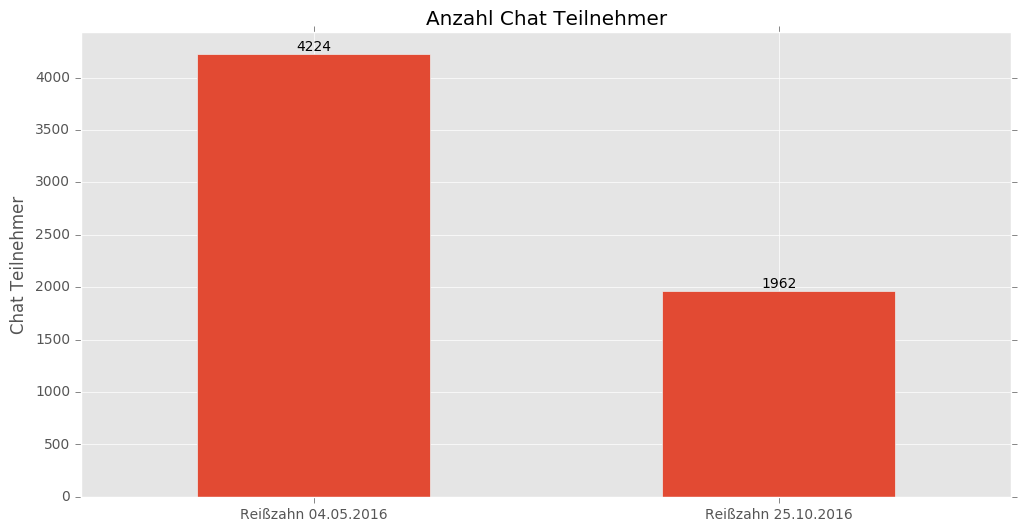

In [14]:
plot = data['chat_participants'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Teilnehmer')
plot.set_ylabel('Chat Teilnehmer')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 0.31942497942061054)

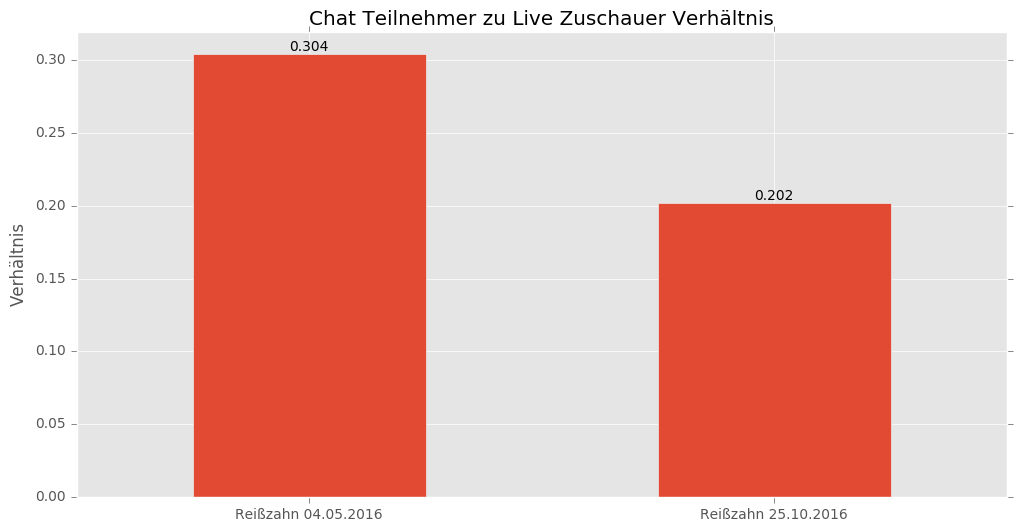

In [15]:
plot = data['chat_ratio'].plot(kind='bar', figsize=(12, 6), title='Chat Teilnehmer zu Live Zuschauer Verhältnis')
plot.set_ylabel('Verhältnis')

annotateBar(plot, ndigits=3)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Video Views

- __Gesamte Views__: Die Summe der Views aller Video Teile
- __Durchschnittliche Views__: Das arithmetische Mittel der Views aus allen Video Teilen

(0, 157391.85000000001)

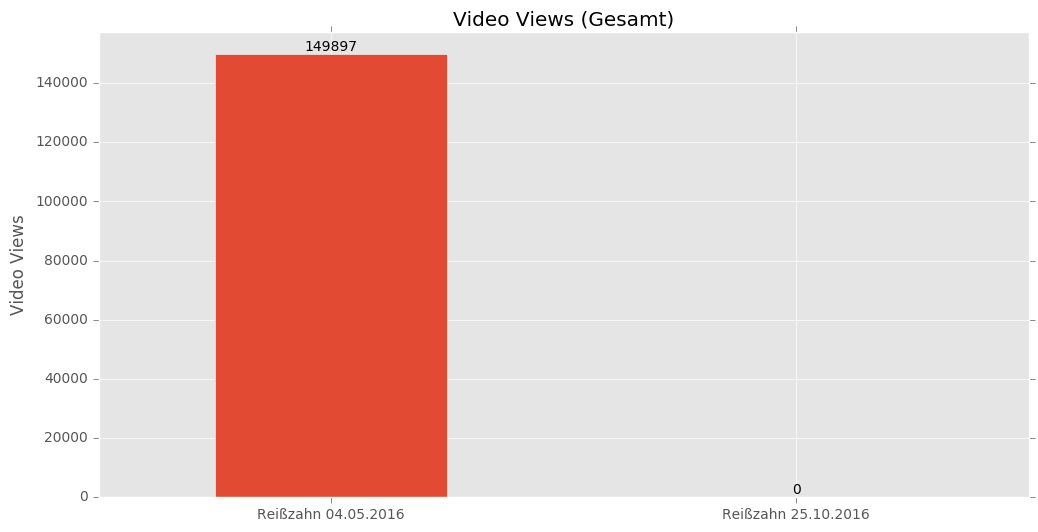

In [16]:
plot = data[['video_views_total']].plot(kind='bar', figsize=(12, 6), legend=False, title='Video Views (Gesamt)')
plot.set_ylabel('Video Views')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 52463.949999999997)

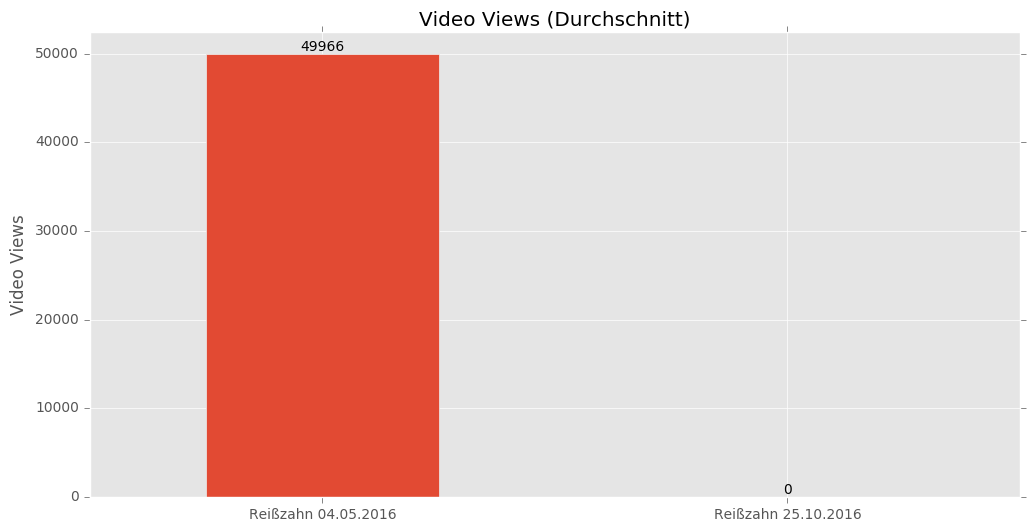

In [17]:
plot = data[['video_views_mean']].plot(kind='bar', figsize=(12, 6), legend=False, rot=0, title='Video Views (Durchschnitt)')
plot.set_ylabel('Video Views')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Video Views Änderung

Die Änderung der Differenz der Video Views vom ersten und zweiten Video Teil. Bei einem positiven Wert wurde der zweite Teil weniger angeschaut als der erste, bei einem negativem Wert entsprechend mehr.

(0, 39.861599261430818)

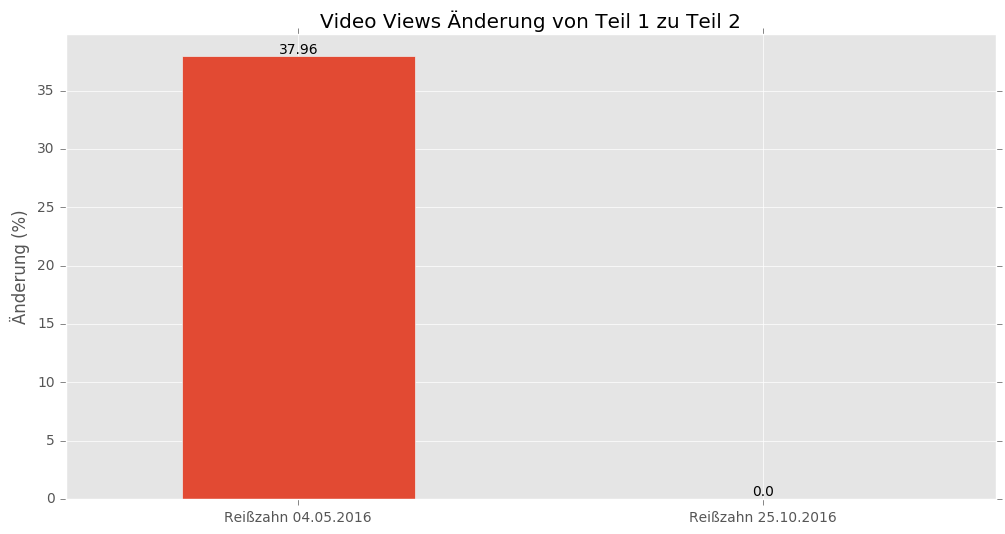

In [18]:
plot = data[['video_views_drop']].plot(kind='bar', figsize=(12, 6), legend=False, title='Video Views Änderung von Teil 1 zu Teil 2')
plot.set_ylabel('Änderung (%)')

annotateBar(plot, ndigits=2)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Video Bewertungen

- __Gesamte Bewertungen__: Die Summe der Bewertungen aller Video Teile
- __Durchschnittliche Bewertungen__: Das arithmetische Mittel der Bewertungen aus allen Video Teilen

(0, 4597.9499999999998)

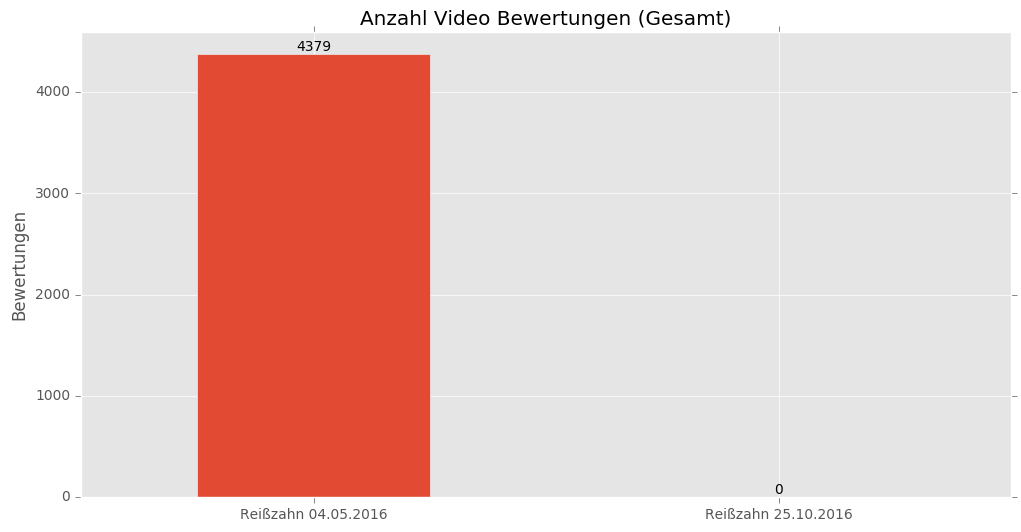

In [19]:
plot = data[['video_ratings_total']].plot(kind='bar', figsize=(12, 6), legend=False, title='Anzahl Video Bewertungen (Gesamt)')
plot.set_ylabel('Bewertungen')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 1532.6500000000001)

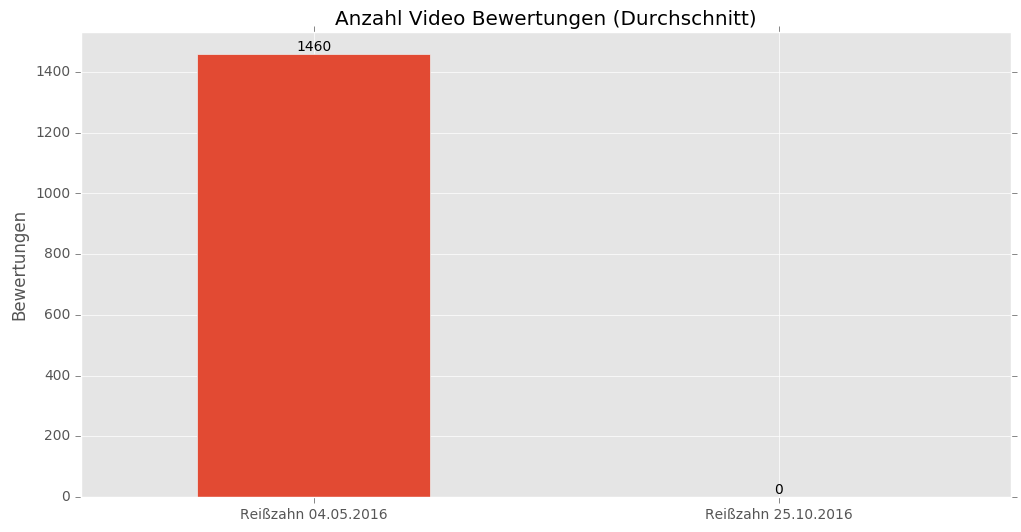

In [20]:
plot = data[['video_ratings_mean']].plot(kind='bar', figsize=(12, 6), legend=False, title='Anzahl Video Bewertungen (Durchschnitt)')
plot.set_ylabel('Bewertungen')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Video Kommentare

- __Gesamte Kommentare__: Die Summe der Kommentare aller Video Teile
- __Durchschnittliche Kommentare__: Das arithmetische Mittel der Kommentare aus allen Video Teilen

(0, 591.14999999999998)

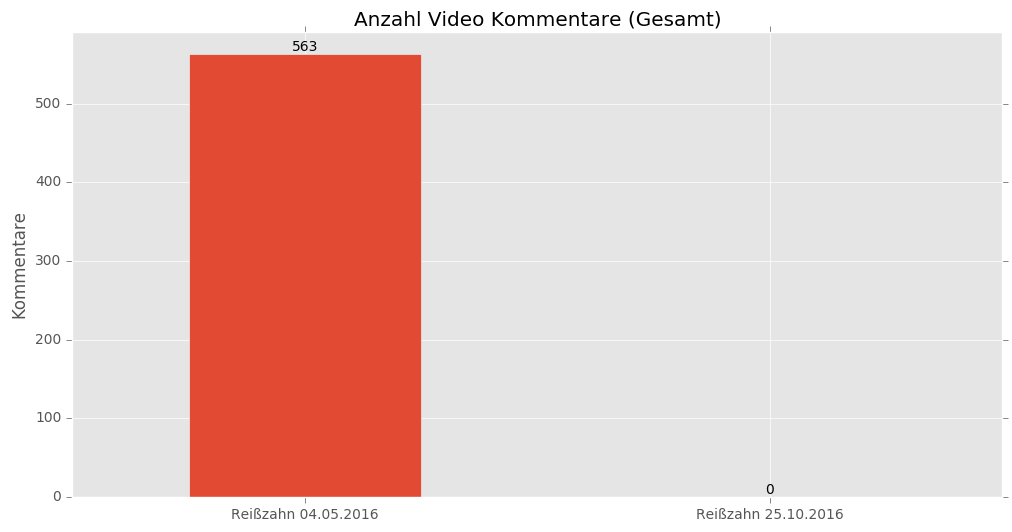

In [21]:
plot = data[['video_comments_total']].plot(kind='bar', figsize=(12, 6), legend=False, title='Anzahl Video Kommentare (Gesamt)')
plot.set_ylabel('Kommentare')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 197.04999999999998)

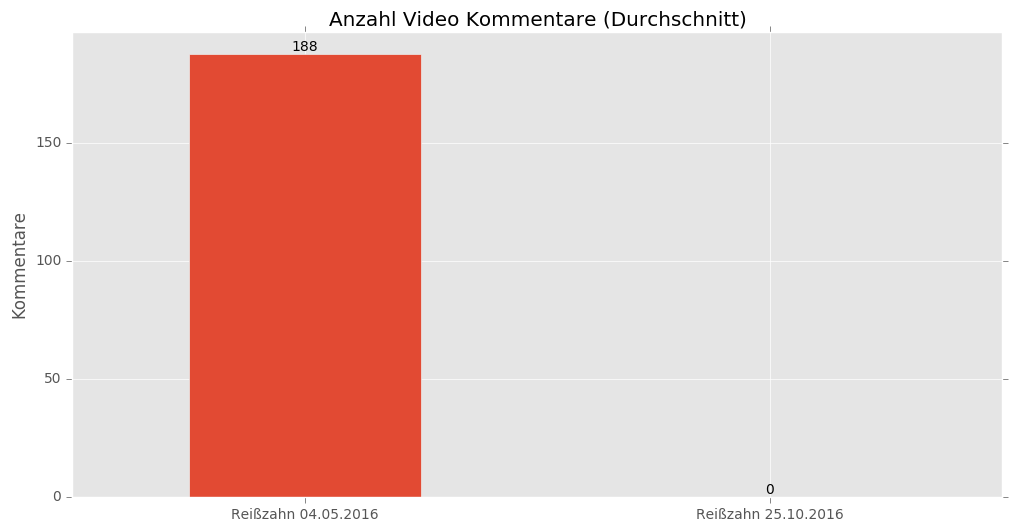

In [22]:
plot = data[['video_comments_mean']].plot(kind='bar', figsize=(12, 6), legend=False, title='Anzahl Video Kommentare (Durchschnitt)')
plot.set_ylabel('Kommentare')

annotateBar(plot)

plt.xticks(rotation=0)
plt.ylim(ymin=0)